In [50]:
%matplotlib inline 



# Frequency and time-frequency sensors analysis

The objective is to show you how to explore the spectral content
of your data (frequency and time-frequency). Here we'll work on Epochs.

We will use this dataset: `somato-dataset`. It contains so-called event
related synchronizations (ERS) / desynchronizations (ERD) in the beta band.


In [2]:
# Authors: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#          Stefan Appelhoff <stefan.appelhoff@mailbox.org>
#          Richard Höchenberger <richard.hoechenberger@gmail.com>
#
# License: BSD (3-clause)
import os.path as op

import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
from mne.datasets import somato

Set parameters



In [3]:
# Explain what the command .data_path() does and why possible
data_path = somato.data_path()
subject = '01'
task = 'somato'
raw_fname = op.join(data_path, 'sub-{}'.format(subject), 'meg',
                    'sub-{}_task-{}_meg.fif'.format(subject, task))

In [4]:
# Setup for reading the raw data
raw = mne.io.read_raw_fif(raw_fname)
events = mne.find_events(raw, stim_channel='STI 014')

Opening raw data file /home/victormp/mne_data/MNE-somato-data/sub-01/meg/sub-01_task-somato_meg.fif...
    Range : 237600 ... 506999 =    791.189 ...  1688.266 secs
Ready.
111 events found
Event IDs: [1]


In [5]:
# picks MEG channels
picks = mne.pick_types(raw.info, meg=True, eeg=False, eog=True, stim=False)

In [6]:
# Construct Epochs
event_id, tmin, tmax = 1, -1., 3.  # Nice aspect of python to define variables thusly
baseline = (None, 0)
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=baseline, reject=dict(grad=4000e-13, eog=350e-6),
                    preload=True)

epochs.resample(200., npad='auto')  # resample to reduce computation time

Not setting metadata
Not setting metadata
111 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 111 events and 1202 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
3 bad epochs dropped


<Epochs |  108 events (all good), -0.998976 - 3.00102 sec, baseline [None, 0], ~206.2 MB, data loaded,
 '1': 108>

## Frequency analysis

We start by exploring the frequence content of our epochs.

* Let's first check out all channel types by averaging across epochs.

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


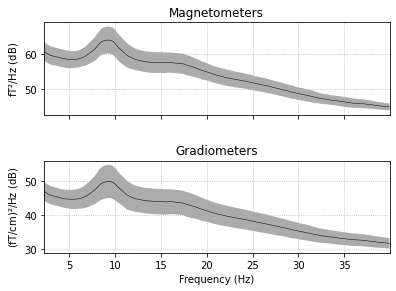

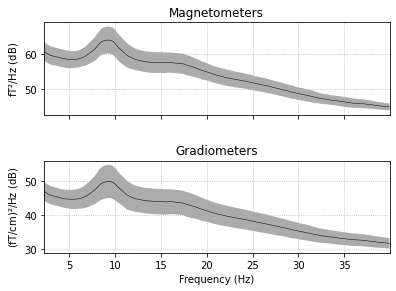

In [7]:
# Make a power spectrum density plot
# grey area: range (max/min), information of spread/variance. 
epochs.plot_psd(fmin=2., fmax=40., average=True, spatial_colors=False)

    Using multitaper spectrum estimation with 7 DPSS windows


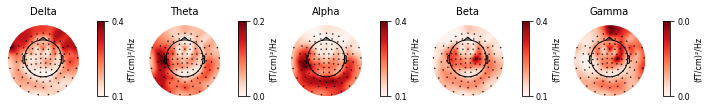

In [8]:
# Now let's take a look at the spatial distributions of the PSD.
bands = [(0, 4, 'Delta'), (4, 8, 'Theta'), (8, 12, 'Alpha'),
                 (12, 30, 'Beta'), (30, 45, 'Gamma')]
epochs.plot_psd_topomap(bands=bands, ch_type='grad', normalize=True); #more blink.

    Using multitaper spectrum estimation with 7 DPSS windows


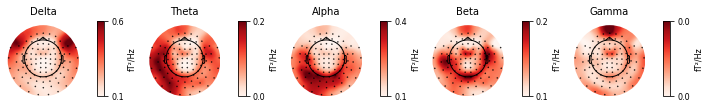

In [9]:
epochs.plot_psd_topomap(bands=bands, ch_type='mag', normalize=True);

Alternatively, you can also create PSDs from Epochs objects with functions
that start with ``psd_`` such as
`mne.time_frequency.psd_multitaper` and `mne.time_frequency.psd_welch`.


Notably, `mne.time_frequency.psd_welch` supports the keyword argument
``average``, which specifies how to estimate the PSD based on the individual
windowed segments. The default is ``average='mean'``, which simply calculates
the arithmetic mean across segments. Specifying ``average='median'``, in
contrast, returns the PSD based on the median of the segments (corrected for
bias relative to the mean), which is a more robust measure.



In [10]:
# pick MEG just gradiometers 
picks = mne.pick_types(epochs.info, meg='grad', eeg=False, eog=True, stim=False) #gradiometers.

Effective window size : 1.280 (s)
Effective window size : 1.280 (s)


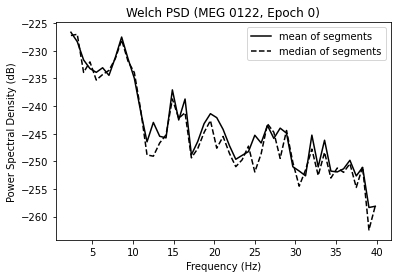

In [11]:
# Estimate PSDs based on "mean" and "median" averaging for comparison.
kwargs = dict(picks=picks, fmin=2, fmax=40, n_jobs=1)
psds_welch_mean, freqs_mean = psd_welch(epochs, average='mean', **kwargs)
psds_welch_median, freqs_median = psd_welch(epochs, average='median', **kwargs)

# Convert power to dB scale.
psds_welch_mean_db = 10 * np.log10(psds_welch_mean) #Welch, the "windowing" approach.
psds_welch_median_db = 10 * np.log10(psds_welch_median)

# We will only plot the PSD for a single sensor in the first epoch.
ch_name = 'MEG 0122'
ch_idx = epochs.info['ch_names'].index(ch_name)
epo_idx = 0

### mean and median define/capture something very different: 
# outliers affect mean - do not affect median. 
# 
_, ax = plt.subplots()
ax.plot(freqs_mean, psds_welch_mean_db[epo_idx, ch_idx, :], color='k',
        ls='-', label='mean of segments')
ax.plot(freqs_median, psds_welch_median_db[epo_idx, ch_idx, :], color='k',
        ls='--', label='median of segments')

ax.set(title='Welch PSD ({}, Epoch {})'.format(ch_name, epo_idx),
       xlabel='Frequency (Hz)', ylabel='Power Spectral Density (dB)')
ax.legend(loc='upper right')
plt.show()

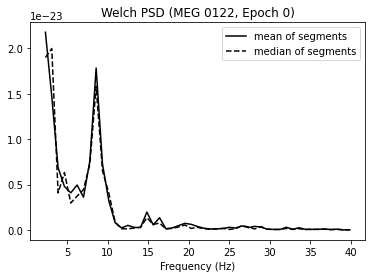

In [12]:
# Let's look at this again but without the dB conversion
# We will only plot the PSD for a single sensor in the first epoch.
ch_name = 'MEG 0122'
ch_idx = epochs.info['ch_names'].index(ch_name)
epo_idx = 0

_, ax = plt.subplots()
ax.plot(freqs_mean, psds_welch_mean[epo_idx, ch_idx, :], color='k',
        ls='-', label='mean of segments')
ax.plot(freqs_median, psds_welch_median[epo_idx, ch_idx, :], color='k',
        ls='--', label='median of segments')

ax.set(title='Welch PSD ({}, Epoch {})'.format(ch_name, epo_idx),
       xlabel='Frequency (Hz)')
ax.legend(loc='upper right')
plt.show()


## Time-frequency analysis: power and inter-trial coherence

We now compute time-frequency representations (TFRs) from our Epochs.
We'll look at power and inter-trial coherence (ITC).

To this we'll use the function `mne.time_frequency.tfr_morlet`
but you can also use `mne.time_frequency.tfr_multitaper`
or `mne.time_frequency.tfr_stockwell`.

In [25]:
# define frequencies of interest (log-spaced)

freqs = np.logspace(*np.log10([6, 35]), num=8)
n_cycles = freqs / 2.  # different number of cycle per frequency
power, itc = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1, picks=picks)

In [35]:
print(freqs) ## parcel into bins, NB: spacing is growing as we go up. 


[ 6.          7.71912254  9.93080879 12.77618833 16.43682721 21.1463139
 27.2051647  35.        ]


## Inspect power

<div class="alert alert-info"><h4>Note</h4><p>The generated figures are interactive. In the topo you can click
    on an image to visualize the data for one sensor.
    You can also select a portion in the time-frequency plane to
    obtain a topomap for a certain time-frequency region.</p></div>



In [14]:
# Let's skip this cell for right now and then we can come back
# %matplotlib qt

Applying baseline correction (mode: logratio)


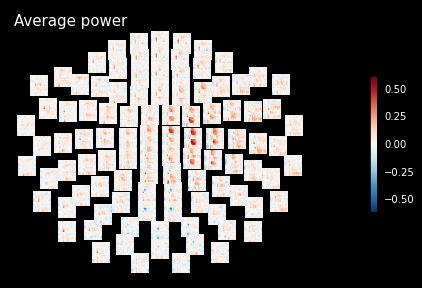

Applying baseline correction (mode: logratio)


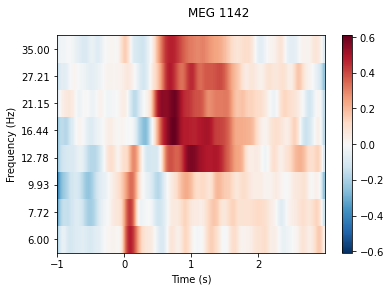

Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)
Applying baseline correction (mode: logratio)


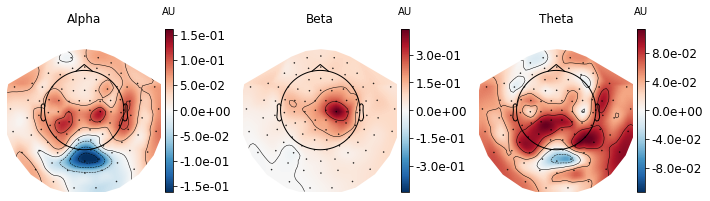

In [49]:
### using log-ratio, could also instead use mean or other stuff
# mean: standard for ERP (evoked stuff). 
# logratihmic: dropping extremes (more realistic?)
# z-score: normalizes data relative to itself.  
# no one agrees on anything. 

power.plot_topo(baseline=(-0.5, 0), mode='logratio', title='Average power') 
power.plot([82], baseline=(-0.5, 0), mode='logratio', title=power.ch_names[82])

fig, axis = plt.subplots(1, 3, figsize=(10, 4))
power.plot_topomap(ch_type='grad', tmin=0.5, tmax=1.5, fmin=8, fmax=12,
                   baseline=(-0.5, 0), mode='logratio', axes=axis[0],
                   title='Alpha', show=False)
power.plot_topomap(ch_type='grad', tmin=0.5, tmax=1.5, fmin=13, fmax=25,
                   baseline=(-0.5, 0), mode='logratio', axes=axis[1],
                   title='Beta', show=False)
power.plot_topomap(ch_type='grad', tmin=0.5, tmax=1.5, fmin=4, fmax=8,
                   baseline=(-0.5, 0), mode='logratio', axes=axis[2],
                   title='Theta', show=False)
mne.viz.tight_layout()
plt.show()

## can chang ethe max/min to get other ranges (bands). 

## Joint Plot
You can also create a joint plot showing both the aggregated TFR
across channels and topomaps at specific times and frequencies to obtain
a quick overview regarding oscillatory effects across time and space.



In [38]:
power.plot_topo?

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


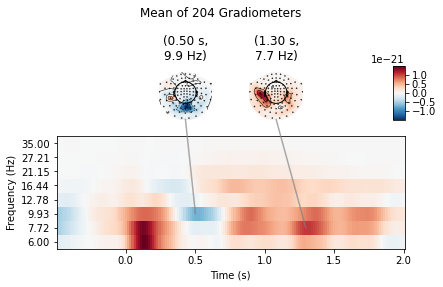

In [36]:
## just alpha (inhibition/excitation) 

power.plot_joint(baseline=(-0.5, 0), mode='mean', tmin=-.5, tmax=2,
                 timefreqs=[(.5, 10), (1.3, 8)]);

## Inspect ITC
example: https://twitter.com/nschawor/status/1207063815830921222



No baseline correction applied


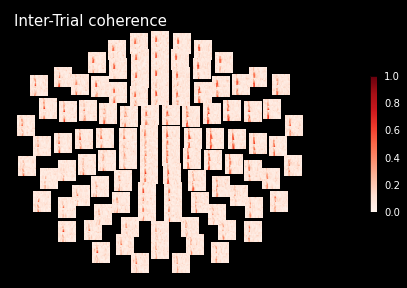

In [24]:
itc.plot_topo(title='Inter-Trial coherence', vmin=0., vmax=1., cmap='Reds');

<div class="alert alert-info"><h4>Note</h4><p>Baseline correction can be applied to power or done in plots.
    To illustrate the baseline correction in plots, the next line is
    commented power.apply_baseline(baseline=(-0.5, 0), mode='logratio')</p></div>

## Exercise

   - Visualize the inter-trial coherence values as topomaps as done with
     power by BAND.

